In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import math

import IPython.display as Image
# import pygraphviz as pgv

import re

In [42]:
columns = [
    "From Problem",
    "To Problem",
    "Year",
    "Blow-Up",
    "Sparse Blow Up",
    "Preserves Sparse?",
    "Parsimonious"
]


reductions = pd.read_csv('KarpReductions.csv', usecols=columns)

In [43]:
def draw(matrix):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))

    # Hide axes
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 

    # Create table
    table = ax.table(cellText=matrix.values, colLabels=matrix.columns, rowLabels=matrix.index, 
                    cellLoc="center", loc="center")

    # Adjust layout
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([i for i in range(len(matrix.index))])  # Adjust column width

    plt.show()

In [44]:
# Here we process everything and make our dictonaries

directReductions = {}
blowUps = {}
spBlowUps = {}
parsReductions = {}

for i in range(len(reductions)):
    fromProblem = reductions["From Problem"][i] 
    toProblem = reductions["To Problem"][i] 
    blowUp = reductions["Blow-Up"][i] 
    spBlowUp = reductions["Sparse Blow Up"][i]
    pars = reductions["Parsimonious"][i] 
    preserv = reductions["Preserves Sparse?"][i]

    # Regular Problem
    redProb = (fromProblem, toProblem)

    directReductions[redProb] = "y"

    if blowUp != "x":
        blowUp = int(blowUp)
        if redProb in blowUps.keys():
            if blowUp < blowUps[redProb]:
                blowUps[redProb] = blowUp
        else:
            blowUps[redProb] = blowUp

    # Sparse problem
    sparseRed = ("Sparse-" + fromProblem, toProblem)
    if spBlowUp != "?":
        spBlowUp = int(spBlowUp)
        if sparseRed in spBlowUps.keys():
            if spBlowUp < spBlowUps[sparseRed]:
                    spBlowUps[sparseRed] = spBlowUp
        else:
            spBlowUps[sparseRed] = spBlowUp

        if preserv == "Yes":
            sparseRed = ("Sparse-" + fromProblem, "Sparse-" + toProblem)
            spBlowUp = int(spBlowUp)
            if sparseRed in spBlowUps.keys():
                if spBlowUp < spBlowUps[sparseRed]:
                        spBlowUps[sparseRed] = spBlowUp
            else:
                spBlowUps[sparseRed] = spBlowUp

    

# Extract unique problem names
problems = sorted(set([key[0] for key in directReductions.keys()] + 
                    [key[1] for key in directReductions.keys()]))

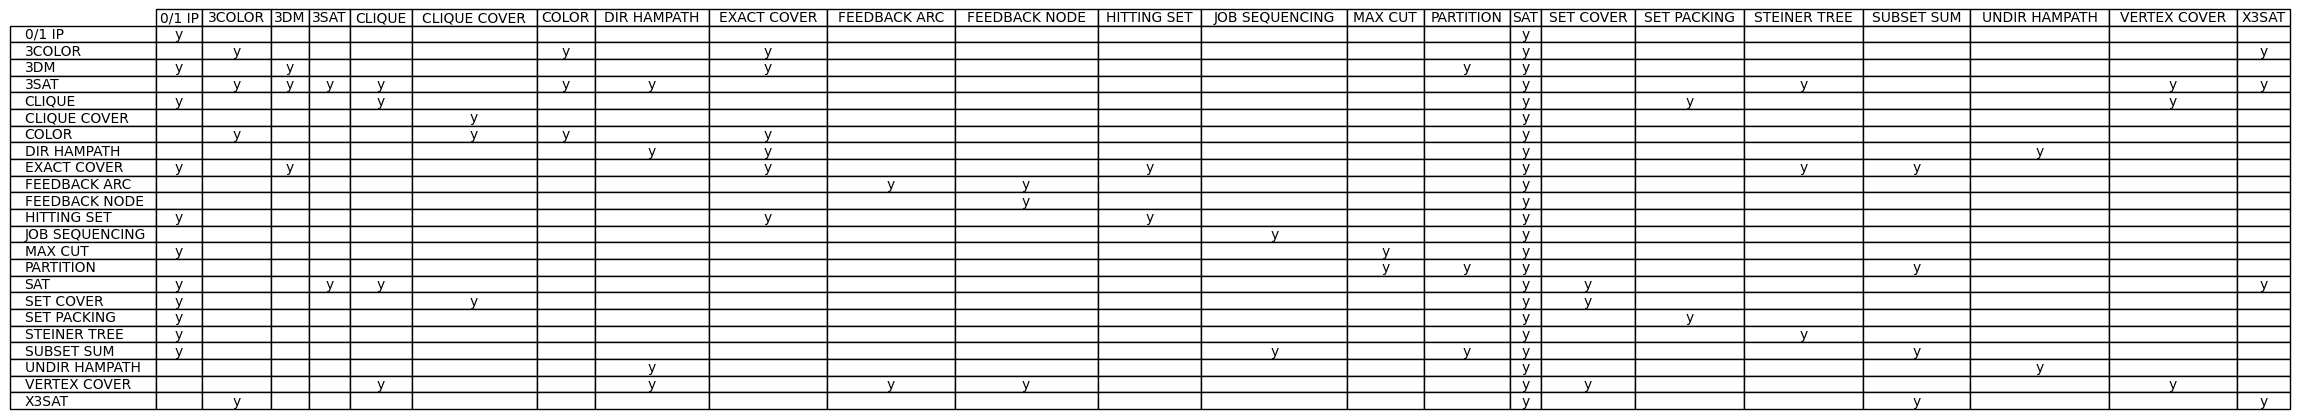

In [45]:
# Create an empty adjacency matrix (DataFrame)
matrix = pd.DataFrame("", index=problems, columns=problems)

# Fill the matrix where reductions exist
for (fromProblem, toProblem), value in directReductions.items():
    matrix.loc[fromProblem, toProblem] = value

# Set diagonal elements to "y"
for problem in problems:
    matrix.loc[problem, problem] = "y"

draw(matrix)


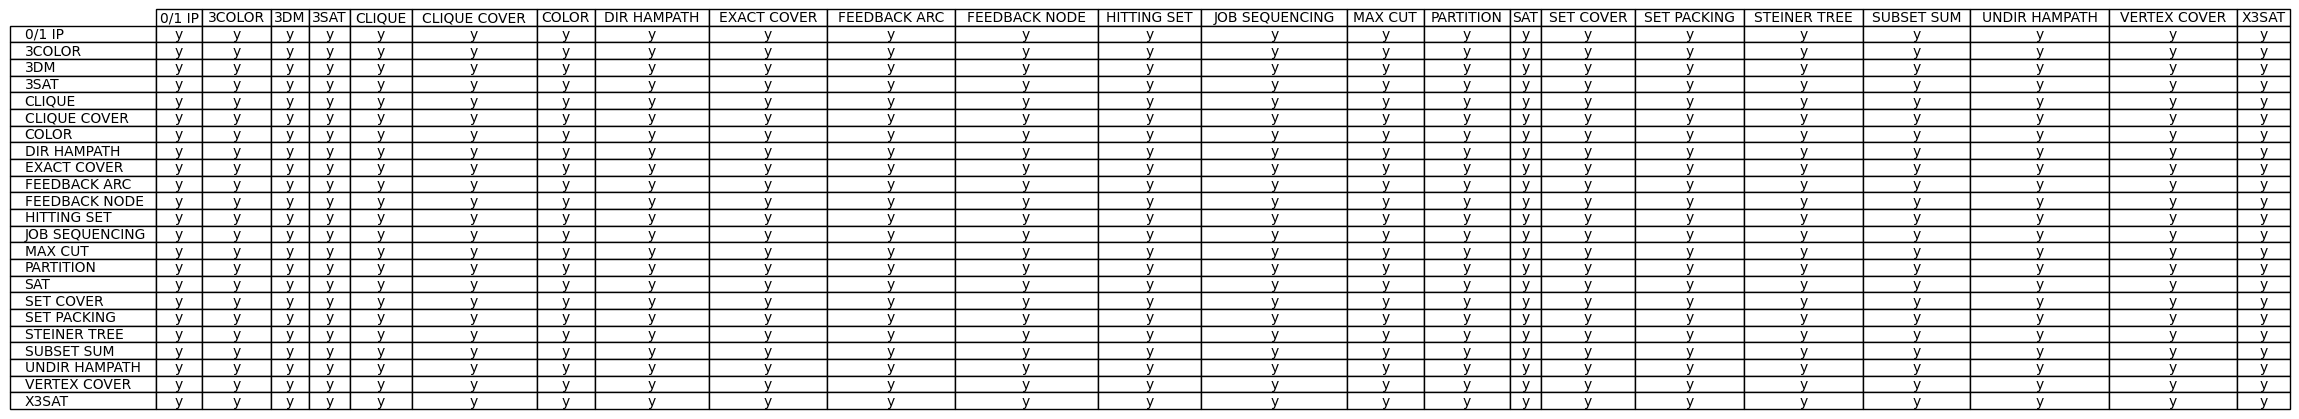

In [46]:
# If we take the transitive closure everything should be true

matrixTC = matrix.copy()

# Extract unique problem names
problems = sorted(set([key[0] for key in directReductions.keys()] + 
                      [key[1] for key in directReductions.keys()]))

for k in problems:
    for i in problems:
        for j in problems:
            if matrixTC.loc[i, k] == "y" and matrixTC.loc[k, j] == "y":
                matrixTC.loc[i, j] = "y"

draw(matrixTC)

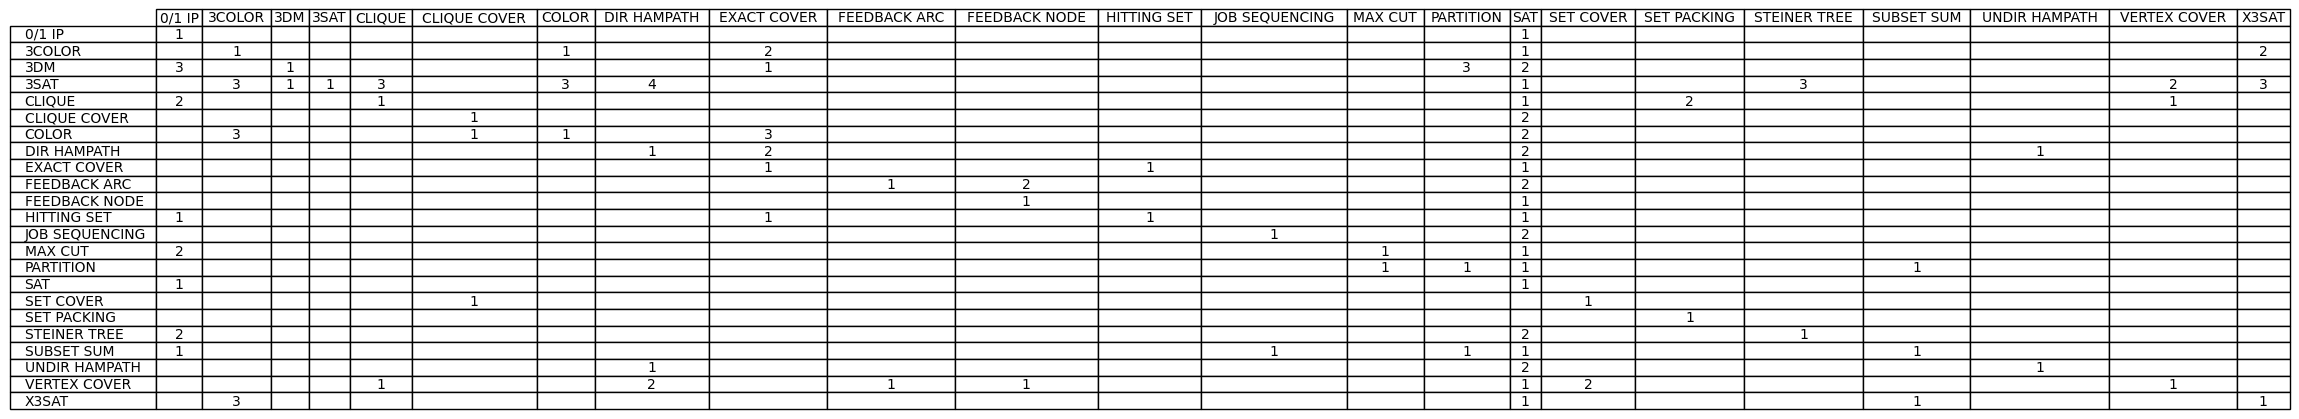

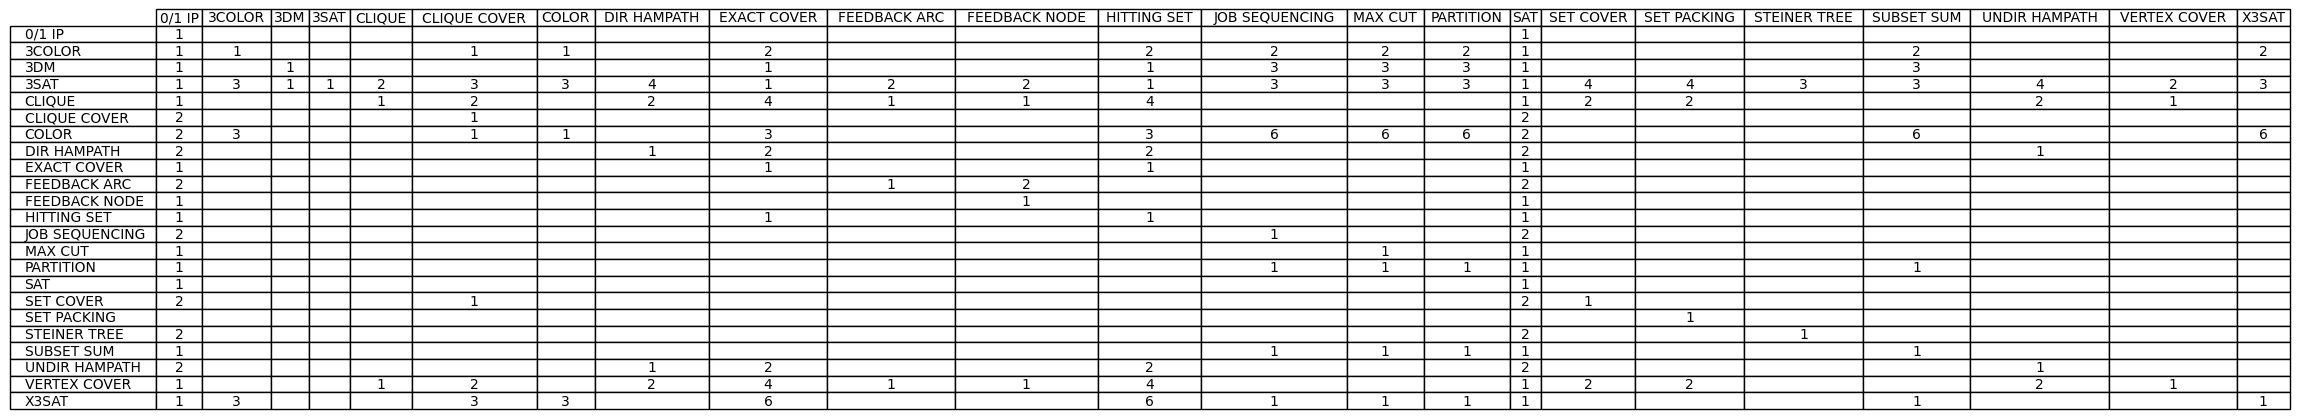

In [47]:
# Now we will track the blow up of reductions ignoring sparsity

# Create an empty adjacency matrix (DataFrame)
matrixBU = pd.DataFrame("", index=problems, columns=problems)

# Fill the matrix where reductions exist
for (fromProblem, toProblem), value in blowUps.items():
    matrixBU.loc[fromProblem, toProblem] = value

# Set diagonal elements to "y"
for problem in problems:
    matrixBU.loc[problem, problem] = 1

draw(matrixBU)

matBUTC = matrixBU.copy()

for k in problems:
    for i in problems:
        for j in problems:
            if matBUTC.loc[i, k] != "" and matBUTC.loc[k, j] != "":
                if matBUTC.loc[i,j] == "":
                    matBUTC.loc[i,j] = matBUTC.loc[i, k] * matBUTC.loc[k, j]
                else:
                    matBUTC.loc[i,j] = min(matBUTC.loc[i,j], matBUTC.loc[i, k] * matBUTC.loc[k, j])

draw(matBUTC)

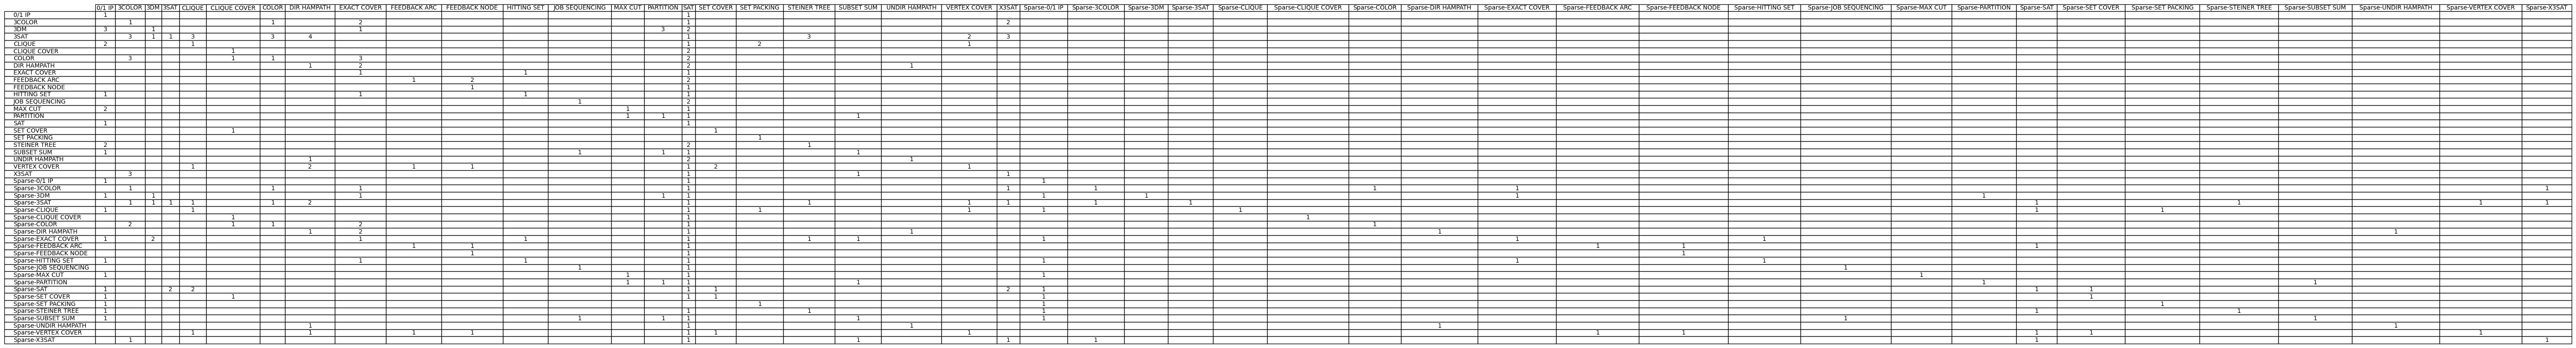

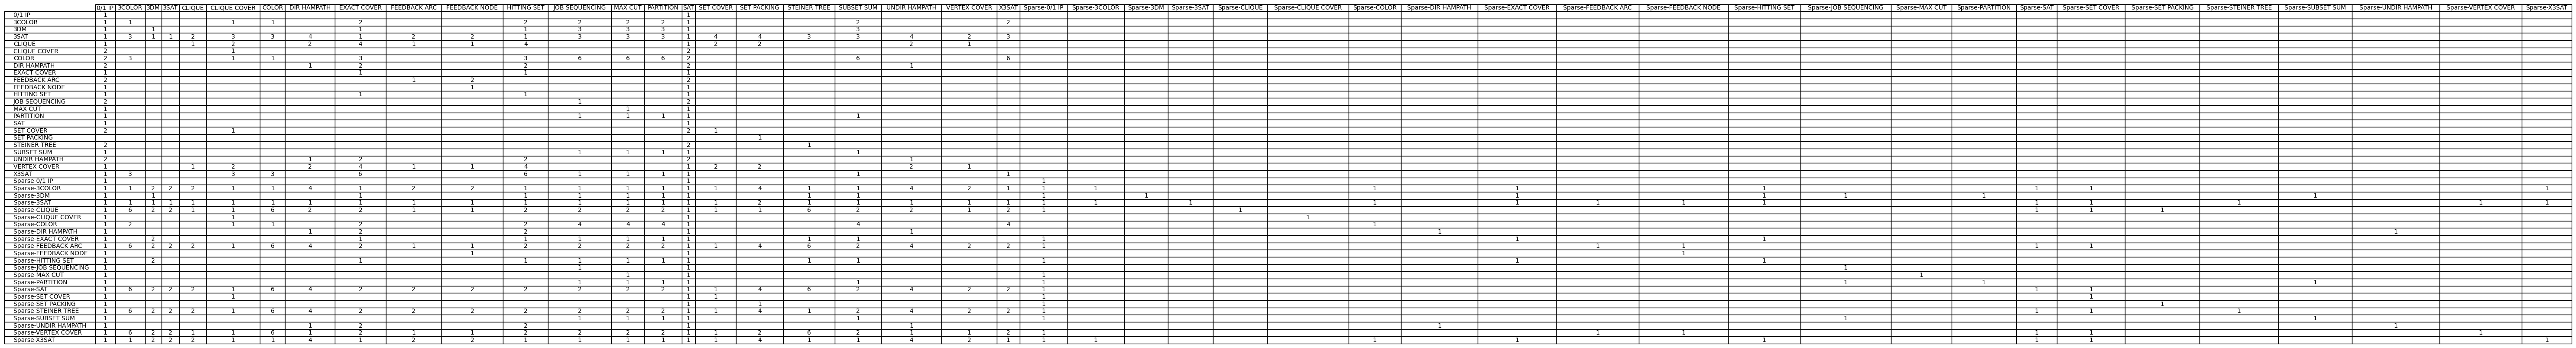

In [48]:
# Draw Table with Sparse Problems



sparseProblems = problems.copy()
for problem in problems:
    sparseProblems.append("Sparse-" + problem)

sparseMatrix = pd.DataFrame("", index=sparseProblems, columns=sparseProblems)

# Fill the matrix where reductions exist
for (fromProblem, toProblem), value in blowUps.items():
    sparseMatrix.loc[fromProblem, toProblem] = value
for (fromProblem, toProblem), value in spBlowUps.items():
    sparseMatrix.loc[fromProblem, toProblem] = value

# Set diagonal elements to "y"
for problem in problems:
    sparseMatrix.loc[problem, problem] = 1
    sparseMatrix.loc["Sparse-" + problem, problem] = 1
    sparseMatrix.loc["Sparse-" + problem, "Sparse-" + problem] = 1

draw(sparseMatrix)

sparseMatrixTC = sparseMatrix.copy()

for k in sparseProblems:
    for i in sparseProblems:
        for j in sparseProblems:
            if sparseMatrixTC.loc[i, k] != "" and sparseMatrixTC.loc[k, j] != "":
                if sparseMatrixTC.loc[i,j] == "":
                    sparseMatrixTC.loc[i,j] = sparseMatrixTC.loc[i, k] * sparseMatrixTC.loc[k, j]
                else:
                    sparseMatrixTC.loc[i,j] = min(sparseMatrixTC.loc[i,j], sparseMatrixTC.loc[i, k] * sparseMatrixTC.loc[k, j])

draw(sparseMatrixTC)

In [49]:
# Get Strongly Connected Components. 
def SCC(matrix, dist=1):
    # Step 1: Build the adjacency list from sparseMatrixTC (only weight 1 edges)
    graph = nx.DiGraph()

    for i in matrix.index:
        for j in matrix.columns:
            if matrix.loc[i,j] != "" and int(matrix.loc[i, j]) <= dist:  # Only consider cheap edges
                graph.add_edge(i, j)

    # Step 2: Compute Strongly Connected Components (SCCs)
    sccs = list(nx.strongly_connected_components(graph))

    # Step 3: Display the SCCs
    for idx, scc in enumerate(sccs, 1):
        print(f"SCC {idx}: {sorted(scc)}")

SCC(sparseMatrixTC)

SCC 1: ['0/1 IP', 'SAT']
SCC 2: ['CLIQUE COVER']
SCC 3: ['COLOR']
SCC 4: ['3COLOR']
SCC 5: ['EXACT COVER', 'HITTING SET']
SCC 6: ['3DM']
SCC 7: ['3SAT']
SCC 8: ['FEEDBACK ARC']
SCC 9: ['FEEDBACK NODE']
SCC 10: ['CLIQUE', 'VERTEX COVER']
SCC 11: ['DIR HAMPATH', 'UNDIR HAMPATH']
SCC 12: ['JOB SEQUENCING']
SCC 13: ['MAX CUT']
SCC 14: ['PARTITION', 'SUBSET SUM']
SCC 15: ['SET COVER']
SCC 16: ['SET PACKING']
SCC 17: ['STEINER TREE']
SCC 18: ['X3SAT']
SCC 19: ['Sparse-0/1 IP']
SCC 20: ['Sparse-COLOR']
SCC 21: ['Sparse-EXACT COVER', 'Sparse-HITTING SET']
SCC 22: ['Sparse-SET COVER']
SCC 23: ['Sparse-SAT']
SCC 24: ['Sparse-3COLOR', 'Sparse-X3SAT']
SCC 25: ['Sparse-JOB SEQUENCING']
SCC 26: ['Sparse-SUBSET SUM']
SCC 27: ['Sparse-PARTITION']
SCC 28: ['Sparse-3DM']
SCC 29: ['Sparse-FEEDBACK NODE']
SCC 30: ['Sparse-FEEDBACK ARC']
SCC 31: ['Sparse-STEINER TREE']
SCC 32: ['Sparse-VERTEX COVER']
SCC 33: ['Sparse-3SAT']
SCC 34: ['Sparse-SET PACKING']
SCC 35: ['Sparse-CLIQUE']
SCC 36: ['Sparse-CLIQUE CO

In [50]:
SCC(sparseMatrixTC, 12)

SCC 1: ['0/1 IP', 'SAT']
SCC 2: ['CLIQUE COVER']
SCC 3: ['EXACT COVER', 'HITTING SET']
SCC 4: ['JOB SEQUENCING']
SCC 5: ['MAX CUT']
SCC 6: ['PARTITION', 'SUBSET SUM']
SCC 7: ['3COLOR', 'COLOR', 'X3SAT']
SCC 8: ['3DM']
SCC 9: ['DIR HAMPATH', 'UNDIR HAMPATH']
SCC 10: ['FEEDBACK NODE']
SCC 11: ['FEEDBACK ARC']
SCC 12: ['SET COVER']
SCC 13: ['SET PACKING']
SCC 14: ['CLIQUE', 'VERTEX COVER']
SCC 15: ['STEINER TREE']
SCC 16: ['3SAT']
SCC 17: ['Sparse-0/1 IP']
SCC 18: ['Sparse-COLOR']
SCC 19: ['Sparse-EXACT COVER', 'Sparse-HITTING SET']
SCC 20: ['Sparse-SET COVER']
SCC 21: ['Sparse-SAT']
SCC 22: ['Sparse-3COLOR', 'Sparse-X3SAT']
SCC 23: ['Sparse-JOB SEQUENCING']
SCC 24: ['Sparse-SUBSET SUM']
SCC 25: ['Sparse-PARTITION']
SCC 26: ['Sparse-3DM']
SCC 27: ['Sparse-FEEDBACK NODE']
SCC 28: ['Sparse-FEEDBACK ARC']
SCC 29: ['Sparse-STEINER TREE']
SCC 30: ['Sparse-VERTEX COVER']
SCC 31: ['Sparse-3SAT']
SCC 32: ['Sparse-SET PACKING']
SCC 33: ['Sparse-CLIQUE']
SCC 34: ['Sparse-CLIQUE COVER']
SCC 35: ['Sp

In [51]:
def printResult(fromProblem, toProblem):
    print(fromProblem, "->", toProblem)
    result = sparseMatrixTC.loc[fromProblem, toProblem]
    if result != "":
        print(result)
    else:
        print("Exponential Length Path")

def printDownFrom(k, fromProblem, sp=""):
    if sp == "":
        listProblems = problems
    else:
        listProblems = sparseProblems
        
    for problem in listProblems:
       result = sparseMatrixTC.loc[fromProblem, problem]
       if result != "":
            if result <= k:
                print(fromProblem, "->", problem, ": ", result)


print("Shorest Path from Sparse-3SAT implies ETH lower bounds")
for problem in sparseProblems:
    # printResult("3SAT", problem)
    printResult("Sparse-3SAT", problem)

Shorest Path from Sparse-3SAT implies ETH lower bounds
Sparse-3SAT -> 0/1 IP
1
Sparse-3SAT -> 3COLOR
1
Sparse-3SAT -> 3DM
1
Sparse-3SAT -> 3SAT
1
Sparse-3SAT -> CLIQUE
1
Sparse-3SAT -> CLIQUE COVER
1
Sparse-3SAT -> COLOR
1
Sparse-3SAT -> DIR HAMPATH
1
Sparse-3SAT -> EXACT COVER
1
Sparse-3SAT -> FEEDBACK ARC
1
Sparse-3SAT -> FEEDBACK NODE
1
Sparse-3SAT -> HITTING SET
1
Sparse-3SAT -> JOB SEQUENCING
1
Sparse-3SAT -> MAX CUT
1
Sparse-3SAT -> PARTITION
1
Sparse-3SAT -> SAT
1
Sparse-3SAT -> SET COVER
1
Sparse-3SAT -> SET PACKING
2
Sparse-3SAT -> STEINER TREE
1
Sparse-3SAT -> SUBSET SUM
1
Sparse-3SAT -> UNDIR HAMPATH
1
Sparse-3SAT -> VERTEX COVER
1
Sparse-3SAT -> X3SAT
1
Sparse-3SAT -> Sparse-0/1 IP
1
Sparse-3SAT -> Sparse-3COLOR
1
Sparse-3SAT -> Sparse-3DM
Exponential Length Path
Sparse-3SAT -> Sparse-3SAT
1
Sparse-3SAT -> Sparse-CLIQUE
Exponential Length Path
Sparse-3SAT -> Sparse-CLIQUE COVER
Exponential Length Path
Sparse-3SAT -> Sparse-COLOR
1
Sparse-3SAT -> Sparse-DIR HAMPATH
Exponenti

In [52]:
#for problem in problems:
    # printResult("3SAT", problem)
    #printResult("Sparse-3SAT", "Sparse-" + problem)

printResult("SAT", "SUBSET SUM")
printResult("X3SAT", "SUBSET SUM")

SAT -> SUBSET SUM
Exponential Length Path
X3SAT -> SUBSET SUM
1


In [53]:
# print("Check Distances to all subexponential time algorithms")

#for problem in problems:
    # printResult("3SAT", problem)
    # printResult("Sparse-" + problem, "Sparse-CLIQUE")

In [54]:
for problem in problems:
    # printResult("3SAT", problem)
    printResult(problem, "SET COVER")

0/1 IP -> SET COVER
Exponential Length Path
3COLOR -> SET COVER
Exponential Length Path
3DM -> SET COVER
Exponential Length Path
3SAT -> SET COVER
4
CLIQUE -> SET COVER
2
CLIQUE COVER -> SET COVER
Exponential Length Path
COLOR -> SET COVER
Exponential Length Path
DIR HAMPATH -> SET COVER
Exponential Length Path
EXACT COVER -> SET COVER
Exponential Length Path
FEEDBACK ARC -> SET COVER
Exponential Length Path
FEEDBACK NODE -> SET COVER
Exponential Length Path
HITTING SET -> SET COVER
Exponential Length Path
JOB SEQUENCING -> SET COVER
Exponential Length Path
MAX CUT -> SET COVER
Exponential Length Path
PARTITION -> SET COVER
Exponential Length Path
SAT -> SET COVER
Exponential Length Path
SET COVER -> SET COVER
1
SET PACKING -> SET COVER
Exponential Length Path
STEINER TREE -> SET COVER
Exponential Length Path
SUBSET SUM -> SET COVER
Exponential Length Path
UNDIR HAMPATH -> SET COVER
Exponential Length Path
VERTEX COVER -> SET COVER
2
X3SAT -> SET COVER
Exponential Length Path


In [55]:
printDownFrom(4, "SUBSET SUM")
printDownFrom(4, "X3SAT")

SUBSET SUM -> 0/1 IP :  1
SUBSET SUM -> JOB SEQUENCING :  1
SUBSET SUM -> MAX CUT :  1
SUBSET SUM -> PARTITION :  1
SUBSET SUM -> SAT :  1
SUBSET SUM -> SUBSET SUM :  1
X3SAT -> 0/1 IP :  1
X3SAT -> 3COLOR :  3
X3SAT -> CLIQUE COVER :  3
X3SAT -> COLOR :  3
X3SAT -> JOB SEQUENCING :  1
X3SAT -> MAX CUT :  1
X3SAT -> PARTITION :  1
X3SAT -> SAT :  1
X3SAT -> SUBSET SUM :  1
X3SAT -> X3SAT :  1


In [59]:
def findPath(start, end):
    G = nx.DiGraph()

    # Iterate over the adjacency matrix to extract edges
    for from_node in sparseMatrix.index:
        for to_node in sparseMatrix.columns:
            weight = sparseMatrix.loc[from_node, to_node]
            if weight != "":
                try:
                    w = float(weight)
                    if w <= 0:
                        continue  # skip invalid weights for log
                    log_weight = math.log(w)
                    G.add_edge(from_node, to_node, weight=log_weight)
                except ValueError:
                    continue  # skip non-numeric values

    try:
        path = nx.dijkstra_path(G, source=start, target=end, weight='weight')
        log_cost = nx.dijkstra_path_length(G, source=start, target=end, weight='weight')
        cost = math.exp(log_cost)  # reverse the log to get product
        return path, cost
    except nx.NetworkXNoPath:
        return None, float('inf')
    except nx.NodeNotFound as e:
        return f"Error: {e}", None

In [60]:
print(findPath("Sparse-3SAT", "MAX CUT"))

(['Sparse-3SAT', 'X3SAT', 'SUBSET SUM', 'PARTITION', 'MAX CUT'], 1.0)


In [58]:
SCCS = nx.strongly_connected_components(G)
SCCS = [scc for scc in SCCS if len(scc) > 1]

G_sccs = nx.DiGraph()

for scc in SCCS:
    for node in scc:
        G_sccs.add_node(node)

    for node in scc:
        for neighbor in G.neighbors(node):
            if neighbor in scc:
                G_sccs.add_edge(
                    node,
                    neighbor
                )

plot_sccs(G_sccs, 'original_sccs.png', None, None)

NameError: name 'G' is not defined